 Structure for part-2: For each method, in which category (high, mid, low) do the synthetic nodes fit in.
- Create class that does the below for a) 2 datasets, b) different distill seeds, c) compression, d) 
- a) Reading the saved (A,X) of distillation methods and converting them into useful data structure for GNN model
- b) Passing through the bench model to find entropy of each node
- c) Assigning the (node, entropy) to high, low, mid : (rank the node based on closness to entropy of the stored list)
- d) Output: 1) Dataframe for each seed and aggregate dataframe for average. Store after every few iterations. Row: Dataset/compression, column: Method/(high,mid,low)

In [31]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2+cu121
12.1


In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
import pandas as pd

In [62]:
def edgeidx_to_adj(edge_index,num_nodes):

    # Initialize an empty adjacency matrix
    adj_dense = torch.zeros((num_nodes, num_nodes), dtype=torch.float)

    # Update the adjacency matrix based on the edge indices
    adj_dense[edge_index[0], edge_index[1]] = 1.0
    adj_dense[edge_index[1], edge_index[0]] = 1.0  # Assuming an undirected graph

    return adj_dense

def visualize_heatmap(adj, heading=""):
    plt.imshow(adj, cmap='viridis', interpolation='nearest',  aspect='auto')
    plt.colorbar()  # Add a colorbar to show the scale
    plt.title(heading)
    plt.show()

def edge_to_adjacency(dataset):
    data = dataset[0]

    data_adj = edgeidx_to_adj(data.edge_index,dataset[0].num_nodes)

    # Extracting indices of nodes in the training mask
    # print(data.train_mask)
    train_mask_indices = torch.nonzero(data.train_mask, as_tuple=False).view(-1)

    # Extracting adjacency matrix for training nodes
    adjacency_matrix = torch.zeros(len(train_mask_indices), len(train_mask_indices))
    for i, src in enumerate(train_mask_indices):
        for j, dest in enumerate(train_mask_indices):
            adjacency_matrix[i, j] = data_adj[src,dest]
    return data_adj
    
    
def adj_feat_matrix_train(dataset):
    data = dataset[0]

    data_adj = edgeidx_to_adj(data.edge_index,dataset[0].num_nodes)

    # Extracting indices of nodes in the training mask
    # print(data.train_mask)
    train_mask_indices = torch.nonzero(data.train_mask, as_tuple=False).view(-1)

    # Extracting adjacency matrix for training nodes
    adjacency_matrix = torch.zeros(len(train_mask_indices), len(train_mask_indices))
    for i, src in enumerate(train_mask_indices):
        for j, dest in enumerate(train_mask_indices):
            adjacency_matrix[i, j] = data_adj[src,dest]

    # Extracting feature matrix for training nodes
    feature_matrix = data.x[train_mask_indices]


    # Sorting nodes by class
#     _, sorted_indices = torch.sort(data.y[train_mask_indices].view(-1))
#     adjacency_matrix = adjacency_matrix[sorted_indices][:, sorted_indices]
#     feature_matrix = feature_matrix[sorted_indices]
    
    # Sorting nodes by class and then by index
    _, sorted_indices = torch.sort(data.y[train_mask_indices])
    sorted_indices_by_class = torch.argsort(data.y[train_mask_indices])
    print(data.y[sorted_indices_by_class])

    # Arrange nodes in adjacency matrix and feature matrix based on sorting
    adjacency_matrix = adjacency_matrix[sorted_indices_by_class][:, sorted_indices_by_class]
    feature_matrix = feature_matrix[sorted_indices_by_class]

    

    # Convert PyTorch tensors to numpy arrays for visualization
    adjacency_matrix_np = adjacency_matrix.cpu().numpy()
    feature_matrix_np = feature_matrix.cpu().numpy()
    print(adjacency_matrix_np)
    
    return adjacency_matrix_np, feature_matrix_np

def visualize_mat(path,heading):
    Adj = torch.load(path)
    # Plotting the heatmap
    plt.imshow(Adj.detach().cpu().numpy(), cmap='viridis', interpolation='nearest', aspect='auto')
    plt.colorbar()  # Add a colorbar to show the scale
    plt.title(heading)
    plt.show()

In [40]:
def plot_cosine(feat, num_nodes, title = 'Cosine Similarity Heatmap' ):
   
    # Calculate cosine similarity between rows (nodes)
    cosine_similarity_matrix = F.cosine_similarity(feat.unsqueeze(1), feat.unsqueeze(0), dim=2)
    
    print(cosine_similarity_matrix.shape)
    
    # Reshape the cosine similarity to create a square matrix
    cosine_similarity_matrix = cosine_similarity_matrix.view(num_nodes, num_nodes)

    # Plotting the heatmap of cosine similarity
    plt.imshow(cosine_similarity_matrix.detach().cpu().numpy(), cmap='viridis', interpolation='nearest', aspect='auto')
    plt.colorbar()  # Add a colorbar to show the scale
    plt.title(title)
    plt.show()

In [35]:
import networkx as nx
from torch_geometric.utils import degree

class GraphAnalysis:
    def __init__(self, graphs=None):
        if graphs==None:
            self.graphs = {}
        else:
            self.graphs = graphs
        self.results_df = None
        self.initialize = None
    
    def add_direct_graph(self,Adj,Feat,graphname):
        self.graphs[graphname] =[Adj,Feat]
    
    def add_graph(self,adj_path,feat_path,graphname):
        Adj = torch.load(adj_path)
        Feat = torch.load(feat_path)
        
        self.graphs[graphname] =[Adj,Feat]

    def degree_distribution(self, graph_name, G):

        # Compute the degree of each node
        degree_sequence = np.array( [d for n, d in G.degree()])
        min_deg = degree_sequence.min()
        max_deg = degree_sequence.max()
        mean_deg = degree_sequence.mean()
        sum_deg = degree_sequence.sum()
        var_deg= degree_sequence.var()
        
        return [min_deg,max_deg,mean_deg,var_deg]

    def clustering_coefficient(self, graph_name, adjacency_matrix):
        G = nx.Graph(adjacency_matrix)
        return nx.average_clustering(G)

    def connected_components(self, graph_name, graph):
#         G = nx.Graph(adjacency_matrix)
#         list(nx.connected_components(G))
        return nx.number_connected_components(graph)

    def graph_density(self, graph_name, G):
#         G = nx.Graph(adjacency_matrix)
        return nx.density(G)


    def graph_diameter(self, graph_name, adjacency_matrix):
        G = nx.Graph(adjacency_matrix)
        return nx.diameter(G)


    def average_centralities(self, graph):
        degree_centrality = nx.degree_centrality(graph)
        closeness_centrality = nx.closeness_centrality(graph)
        betweenness_centrality = nx.betweenness_centrality(graph)
        eigenvector_centrality = nx.eigenvector_centrality(graph)

        avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
        avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
        avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
        avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)

        return {
            "Degree Centrality": avg_degree_centrality,
            "Closeness Centrality": avg_closeness_centrality,
            "Betweenness Centrality": avg_betweenness_centrality,
            "Eigenvector Centrality": avg_eigenvector_centrality,
        }

    def average_cliques(self, graph_name, adjacency_matrix):
        G = nx.Graph(adjacency_matrix)
        cliques = list(nx.find_cliques(G))
        avg_clique_size = sum(len(clique) for clique in cliques) / len(cliques)
        return  avg_clique_size


    def find_all(self):
        for graph_name, matrices in self.graphs.items():
            adjacency_matrix, feature_matrix = matrices

            # Convert adjacency matrix to a networkx graph
            G = nx.Graph()
            num_nodes = adjacency_matrix.shape[0]
            G.add_nodes_from(range(num_nodes))

            edges = [(i, j) for i in range(num_nodes) for j in range(num_nodes) if adjacency_matrix[i, j] > 0.05]
            G.add_edges_from(edges)

            # Call other methods with the networkx graph
            # Number of nodes
            number_of_nodes = nx.number_of_nodes(G)

            # Number of edges
            number_of_edges = nx.number_of_edges(G)
            min_deg,max_deg,mean_deg,var_deg = self.degree_distribution(graph_name, G)
            centraility = self.average_centralities(G)
            
            properties = {
                "Num-Nodes":number_of_nodes,
                "Num-edge":number_of_edges,
                "Min Degree":min_deg ,
                "Max Degree":max_deg ,
                "Mean Degree":mean_deg ,
                "Var Degree":var_deg ,
                "Clustering Coefficient": self.clustering_coefficient(graph_name, G),
                "Connected Components": self.connected_components(graph_name, G),
                "Graph Density": self.graph_density(graph_name, G),
#                 "Graph Diameter": self.graph_diameter(graph_name, G),
                "Average Cliques": self.average_cliques(graph_name, G),

            }
            properties.update(centraility)
#             print(properties)
            self.store(graph_name, properties)

    def store(self, graph_name, properties):
        if self.initialize == None:
            
            row = properties.keys()
            col = self.graphs.keys()
            self.results_df=pd.DataFrame(columns = col, index = row)
            self.initialize = 1
            
            
        self.results_df[graph_name] = properties.values()

    # After storing all properties, transpose the dataframe
    


    def save_results(self, file_path="graph_analysis_results.csv"):
#         self.results_df = self.results_df.transpose()
        self.results_df.to_csv(file_path, index=False)





In [67]:
graph_analysis = GraphAnalysis()

In [68]:
print(graph_analysis.graphs)

{}


### Original datasets - How do they look

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])
42.0


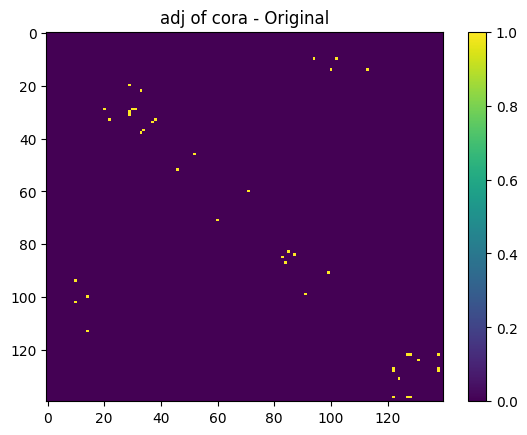

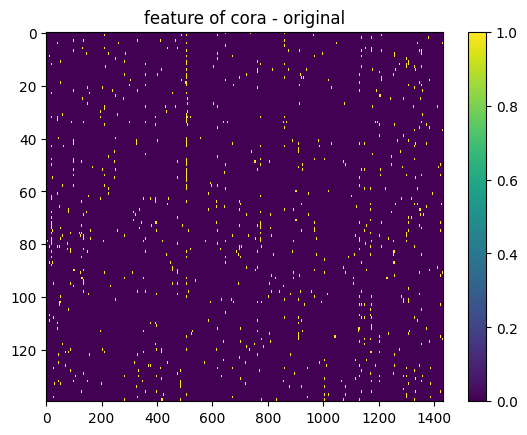

In [69]:
# Load the Cora dataset
dataset = Planetoid(root='data', name='cora')
adj_cora, feat_cora = adj_feat_matrix_train(dataset)
# Plotting the heatmap
visualize_heatmap(adj_cora, "adj of cora - Original")
visualize_heatmap(feat_cora, "feature of cora - original")
graph_analysis.add_direct_graph(edge_to_adjacency(dataset),dataset[0].x,"cora")

torch.Size([140, 140])


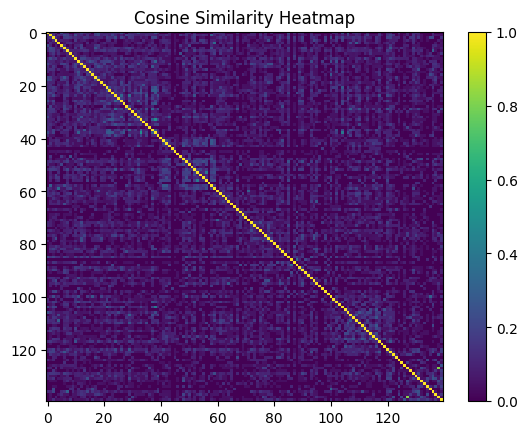

In [70]:
tensor = torch.tensor(feat_cora)
plot_cosine(tensor,140)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
16.0


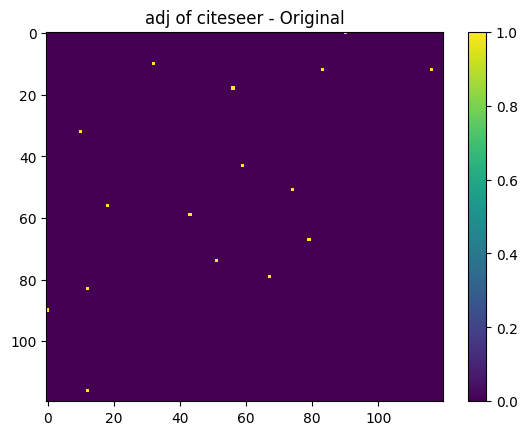

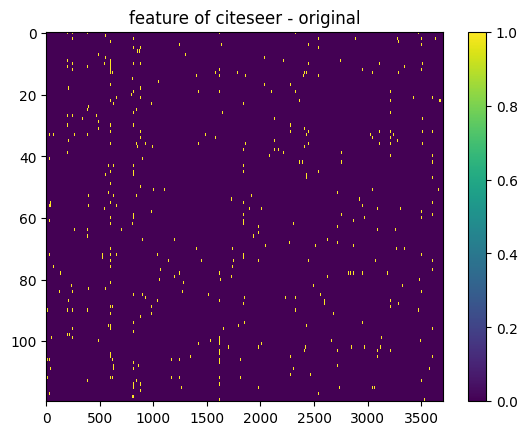

In [79]:
# Load the Citeseer dataset
dataset = Planetoid(root='data', name='citeseer')
adj, feat = adj_feat_matrix_train(dataset)
# Plotting the heatmap
visualize_heatmap(adj, "adj of citeseer - Original")
visualize_heatmap(feat, "feature of citeseer - original")
graph_analysis.add_direct_graph(edge_to_adjacency(dataset),dataset[0].x,"citeseer")

torch.Size([120, 120])


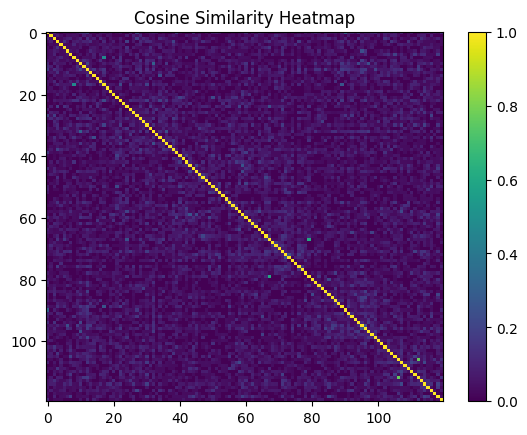

In [71]:
tensor = torch.tensor(feat)
plot_cosine(tensor,120)

In [72]:
def visualize_distil_data(adj_path, feat_path,method,dataname):
    path= adj_path # "distil_data/adj_citeseer_0.5_1_0.pt"
    title = "HeatMap of Adj - " + method + "  data: " +dataname
    visualize_mat(path,title)
    
    path= feat_path
    title = "HeatMap of Feature - "+ method + "  data: " +dataname
    visualize_mat(path,title)
    feat = torch.load(path)
    n = len(feat)
    plot_cosine(feat,n, " Cosine Similarity between features") 

## 1.1 Visualizing - DATASET: Cora,    METHOD: GCOND

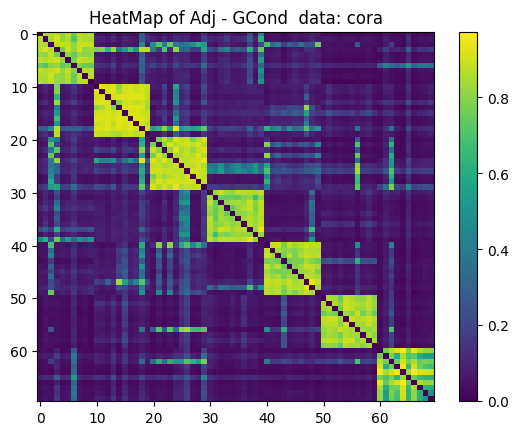

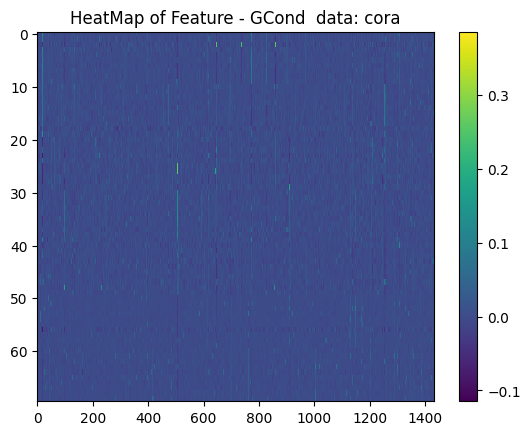

torch.Size([70, 70])


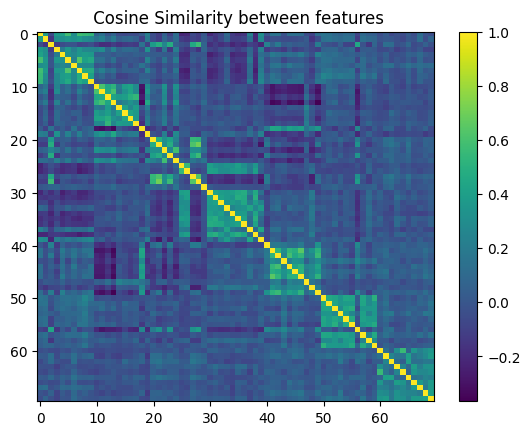

In [73]:
adj_path="distil_data/gcond/adj_cora_0.5_1_0.pt"
feat_path ="distil_data/gcond/feat_cora_0.5_1_0.pt"
method = "GCond"
dataname = "cora"
visualize_distil_data(adj_path,feat_path,method,dataname)
graph_analysis.add_graph(adj_path,feat_path,method+ "-"+ dataname)

## 1.2 Visualizing - DATASET: Citeseer,    METHOD: GCOND

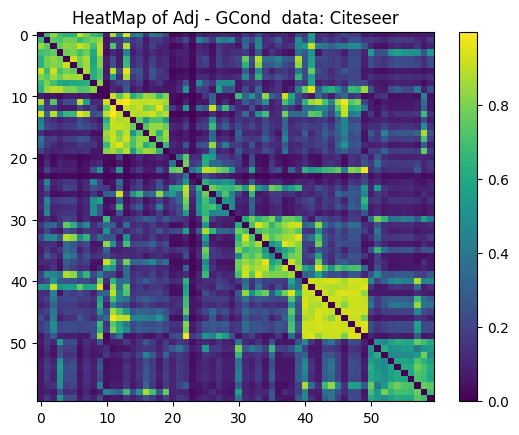

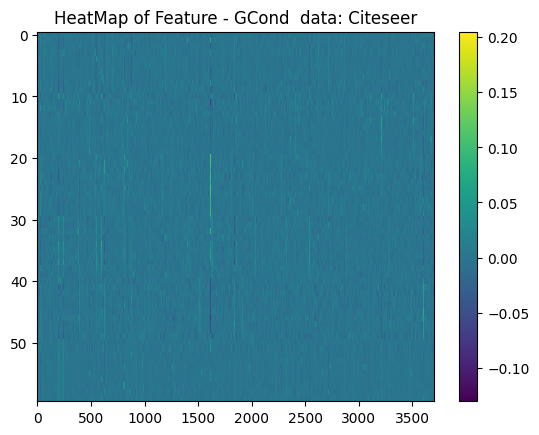

torch.Size([60, 60])


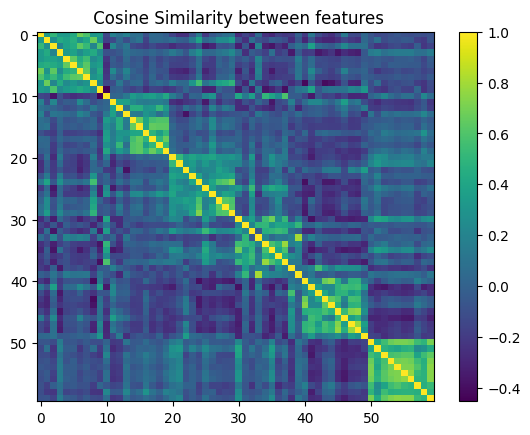

In [74]:
adj_path="distil_data/gcond/adj_citeseer_0.5_1_0.pt"
feat_path ="distil_data/gcond/feat_citeseer_0.5_1_0.pt"
method = "GCond"
dataname = "Citeseer"
visualize_distil_data(adj_path,feat_path,method,dataname)
graph_analysis.add_graph(adj_path,feat_path,method+ "-"+ dataname)

## 2.1 Method: SGDD , dataset: Cora

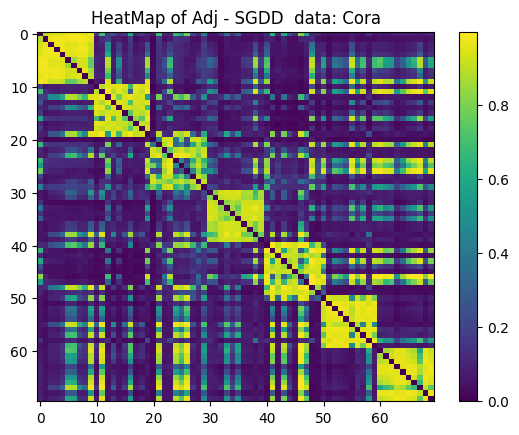

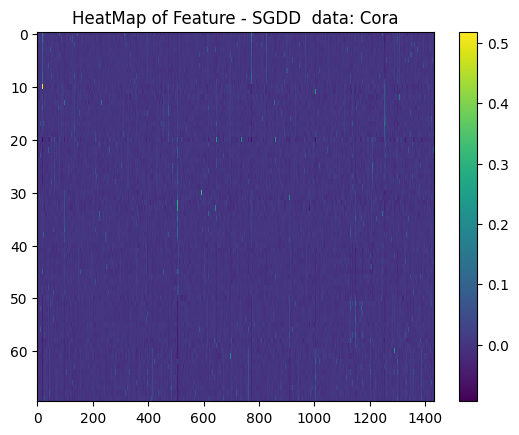

torch.Size([70, 70])


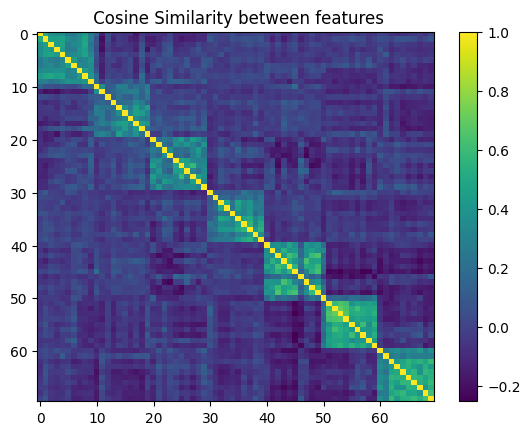

In [75]:
adj_path="distil_data/sgdd/adj_cora_0.5_15.pt"
feat_path ="distil_data/sgdd/feat_cora_0.5_15.pt"
method = "SGDD"
dataname = "Cora"
visualize_distil_data(adj_path,feat_path,method,dataname)
graph_analysis.add_graph(adj_path,feat_path,method+ "-"+ dataname)

## 2.2 Method: SGDD , dataset: Citeseer


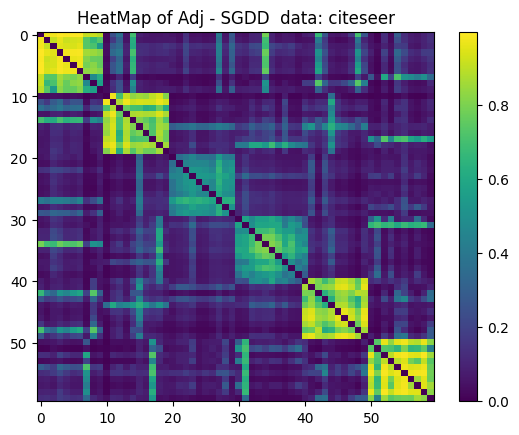

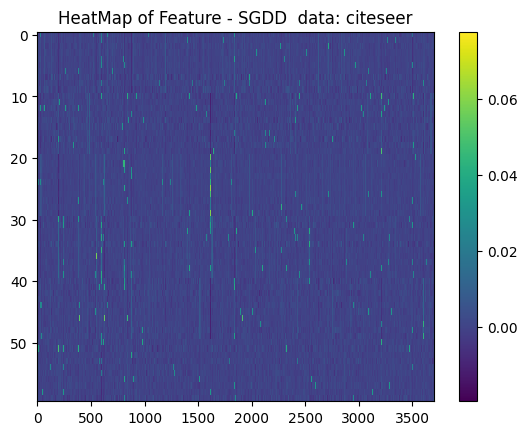

torch.Size([60, 60])


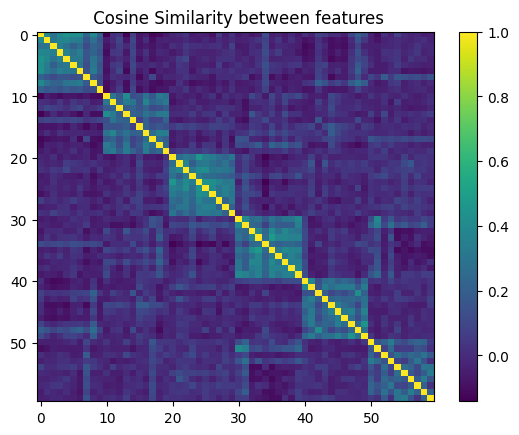

In [76]:
adj_path="distil_data/sgdd/adj_citeseer_0.5_1.pt"
feat_path ="distil_data/sgdd/feat_citeseer_0.5_1.pt"
method = "SGDD"
dataname = "citeseer"
visualize_distil_data(adj_path,feat_path,method,dataname)
graph_analysis.add_graph(adj_path,feat_path,method+ "-"+ dataname)

## 3.1 Method: SFGC , Data: Cora

In [77]:
adj_path="distil_data/sfgc_adj_cora_0.5_best_ntk_score_15.pt"
feat_path = "distil_data/sfgc_feat_cora_0.5_best_ntk_score_15.pt"
method = "SFGC"
dataname = "cora"
visualize_distil_data(adj_path,feat_path,method,dataname)
# graph_analysis.add_graph(adj_path,feat_path,method+ "-"+ dataname)

FileNotFoundError: [Errno 2] No such file or directory: 'distil_data/sfgc_adj_cora_0.5_best_ntk_score_15.pt'

## 3.2 Method: SFGC , Data: Citeseer

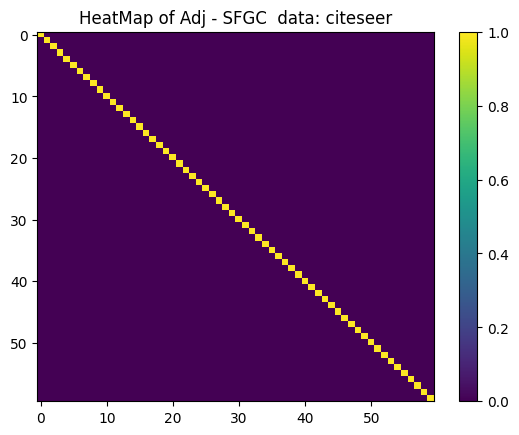

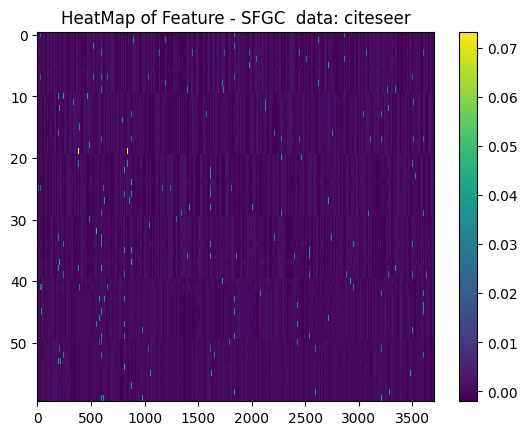

torch.Size([60, 60])


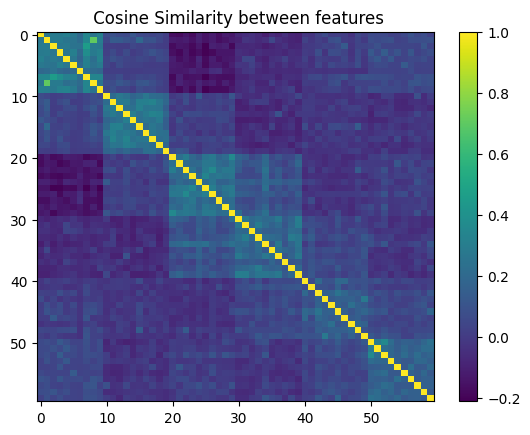

In [18]:
adj_path="distil_data/sfgc_adj_citeseer_0.5_best_ntk_score_15.pt"
feat_path ="distil_data/sfgc_feat_citeseer_0.5_best_ntk_score_15.pt"
method = "SFGC"
dataname = "citeseer"
visualize_distil_data(adj_path,feat_path,method,dataname)
# graph_analysis.add_graph(adj_path,feat_path,method+ "-"+ dataname)

## Different Attribues of various graphs

In [84]:
graph_analysis.find_all()
graph_analysis.save_results()
graph_analysis.results_df

,cora,GCond-cora,GCond-Citeseer,SGDD-Cora,SGDD-citeseer,citeseer
Num-Nodes,2708.000000,70.000000,60.000000,70.000000,60.000000,3327.000000
Num-edge,5278.000000,1667.000000,1643.000000,1939.000000,1406.000000,4552.000000
Min Degree,1.000000,16.000000,20.000000,15.000000,12.000000,0.000000
Max Degree,168.000000,69.000000,59.000000,69.000000,58.000000,99.000000
Mean Degree,3.898080,47.628571,54.766667,55.400000,46.866667,2.736399
Var Degree,27.330085,172.490612,34.078889,97.782857,73.482222,11.430064
Clustering Coefficient,0.240673,0.834313,0.950871,0.856337,0.859746,0.141471
Connected Components,78.000000,1.000000,1.000000,1.000000,1.000000,438.000000
Graph Density,0.001440,0.690269,0.928249,0.802899,0.794350,0.000823
Average Cliques,2.371597,24.237898,39.486772,26.753093,24.662356,2.257037


In [20]:
graph_analysis.graphs

{'cora': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 1., 0.]]),
  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])],
 'citeseer': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

### CORA and CITESEER AJD of SGDD

### How does original Cora/ Citeseer data look

In [21]:
# data = Planetoid(root='data', name= "cora")

In [22]:
# adj_sparse = to_dense_adj(data.edge_index).squeeze()

# # Convert the sparse adjacency matrix to a dense PyTorch tensor
# adj_dense = adj_sparse.to_dense()

# # Plotting the heatmap
# plt.imshow(adj_dense.numpy(), cmap='viridis', interpolation='nearest')

# plt.colorbar()  # Add a colorbar to show the scale
# plt.title('Heatmap of Cora Dataset Adjacency Matrix')
# plt.show()

In [23]:
# # Number of nodes
# number_of_nodes = nx.number_of_nodes(G)

# # Number of edges
# number_of_edges = nx.number_of_edges(G)

# # Graph density
# density = nx.density(G)

# # Average degree
# average_degree = sum(dict(G.degree()).values()) / number_of_nodes

# # Compute the degree of each node
# degree_sequence = np.array( [d for n, d in G.degree()])
# min_deg = degree_sequence.min()
# max_deg = degree_sequence.max()
# mean_deg = degree_sequence.mean()
# sum_deg = degree_sequence.sum()
# var_deg= degree_sequence.var()
# # 
# # Plot the degree distribution

# # Compute the clustering coefficient
# average_clustering = nx.average_clustering(G)

# # Compute the average shortest path length
# average_shortest_path_length = nx.average_shortest_path_length(G)

# # Eccentricity
# eccentricity = nx.eccentricity(G)

# # Diameter
# diameter = nx.diameter(G)

# # Transitivity
# transitivity = nx.transitivity(G)

# # Convert all the features into a numpy array
# features = np.array([
#                   number_of_edges,
#                   density,
#                   average_degree,
#                   min_deg, max_deg, mean_deg, sum_deg,var_deg,
#                   average_clustering,
#                   average_shortest_path_length,
#                   diameter,
#                   transitivity
#                   ])
# #print(number_of_nodes)
# return features

In [24]:
print(graph_analysis.results_df)

                               cora     citeseer   GCond-cora  GCond-Citeseer  \
Num-Nodes               2708.000000  3327.000000    70.000000       60.000000   
Num-edge                5278.000000  4552.000000  1667.000000     1643.000000   
Min Degree                 1.000000     0.000000    16.000000       20.000000   
Max Degree               168.000000    99.000000    69.000000       59.000000   
Mean Degree                3.898080     2.736399    47.628571       54.766667   
Var Degree                27.330085    11.430064   172.490612       34.078889   
Clustering Coefficient     0.240673     0.141471     0.834313        0.950871   
Connected Components      78.000000   438.000000     1.000000        1.000000   
Graph Density              0.001440     0.000823     0.690269        0.928249   
Average Cliques            2.371597     2.257037    24.237898       39.486772   
Degree Centrality          0.001440     0.000823     0.690269        0.928249   
Closeness Centrality       0

FLickr - GCOND

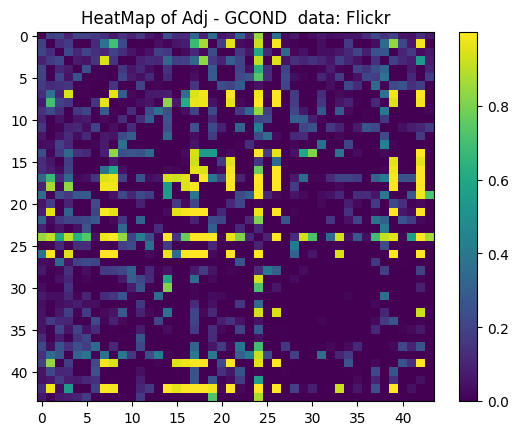

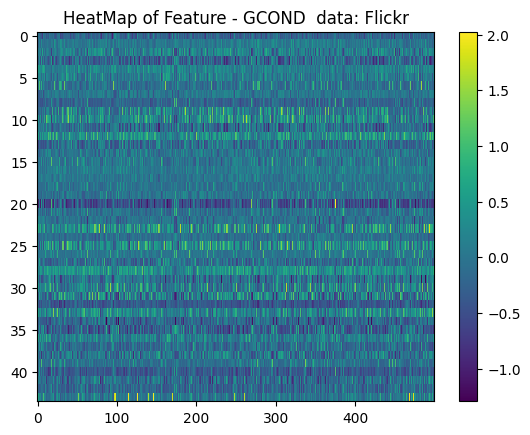

torch.Size([44, 44])


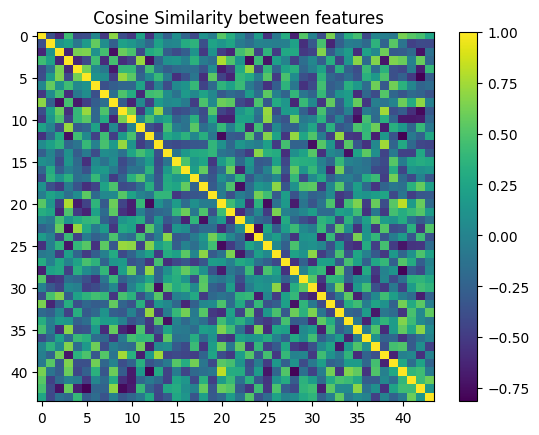

In [83]:
# /home/evl/jkakka4/data/exp3/
adj_path="distil_data/gcond/adj_flickr_0.001_1.pt"
feat_path ="distil_data/gcond/feat_flickr_0.001_1.pt"
method = "GCOND"
dataname = "Flickr"
visualize_distil_data(adj_path,feat_path,method,dataname)

Flickr - SGDD

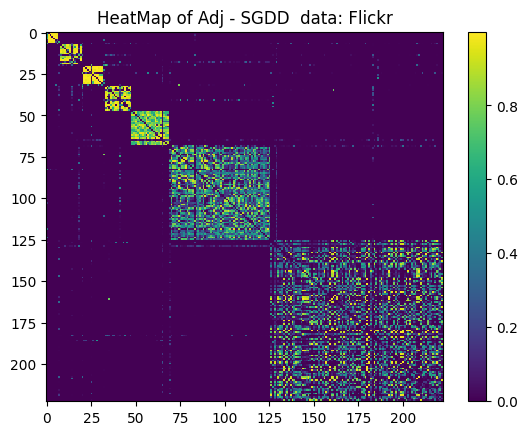

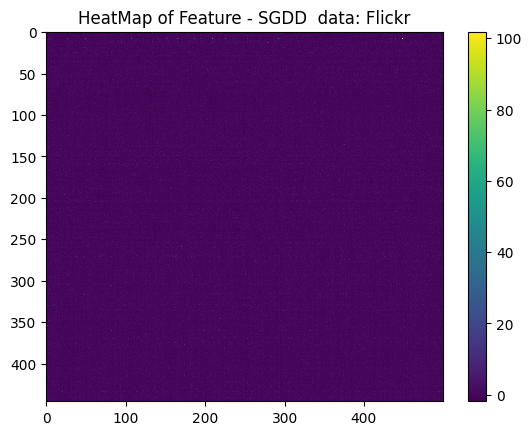

torch.Size([446, 446])


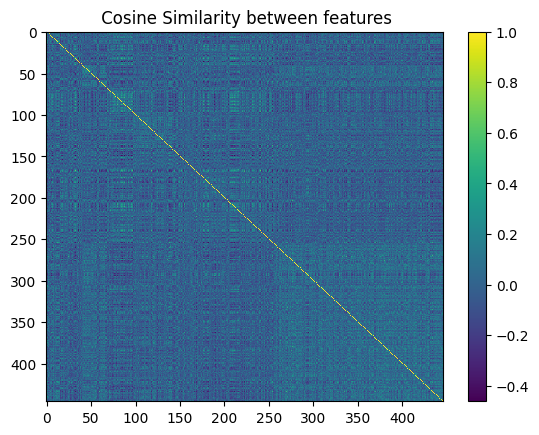

In [30]:
adj_path="distil_data/sgdd/adj_flickr_0.005_1.pt"
feat_path ="distil_data/sgdd/feat_flickr_0.01_15.pt"
method = "SGDD"
dataname = "Flickr"
visualize_distil_data(adj_path,feat_path,method,dataname)

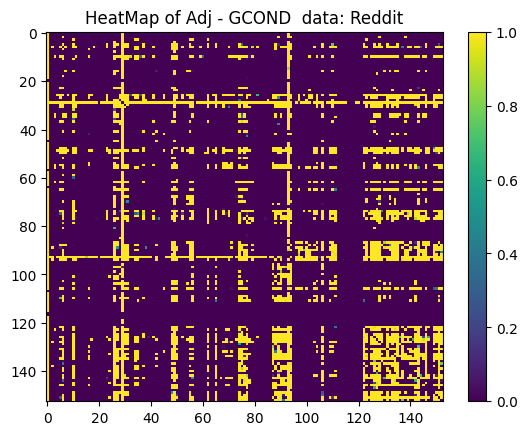

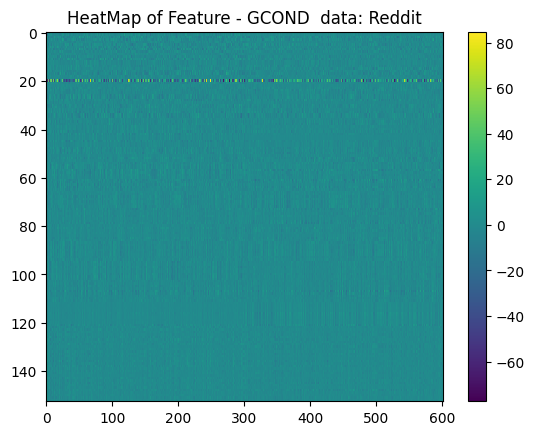

torch.Size([153, 153])


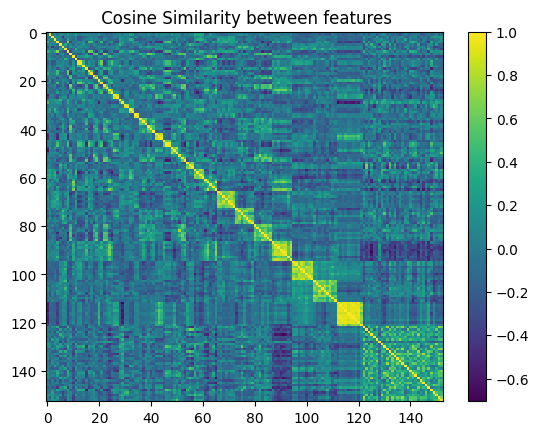

In [14]:
adj_path="distil_data/gcond/adj_reddit_0.001_85.pt"
feat_path ="distil_data/gcond/feat_reddit_0.001_85.pt"
method = "GCOND"
dataname = "Reddit"
visualize_distil_data(adj_path,feat_path,method,dataname)

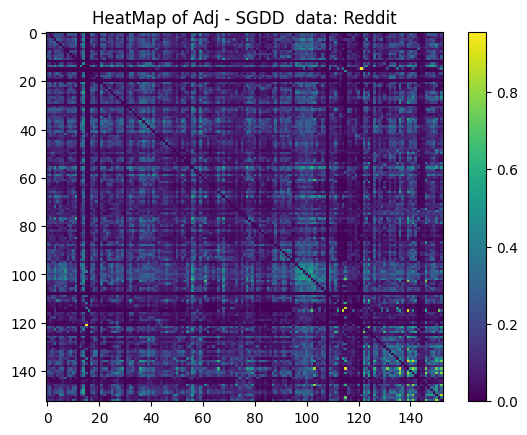

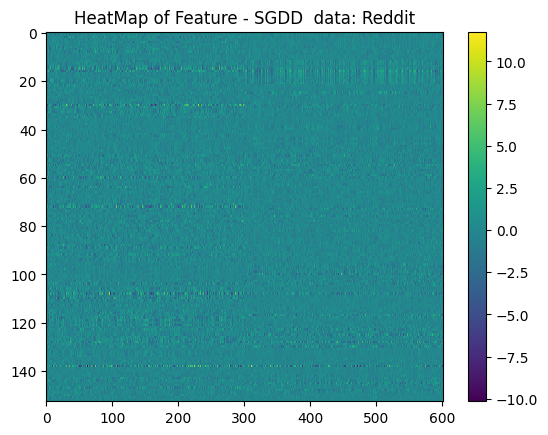

torch.Size([153, 153])


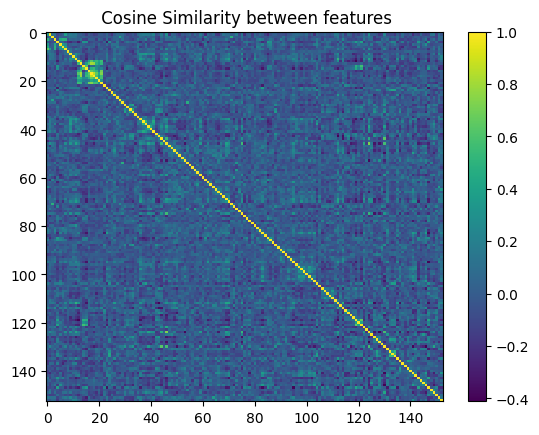

In [13]:
adj_path="distil_data/sgdd/adj_reddit_0.001_85.pt"
feat_path ="distil_data/sgdd/feat_reddit_0.001_85.pt"
method = "SGDD"
dataname = "Reddit"
visualize_distil_data(adj_path,feat_path,method,dataname)